In [37]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc

!pip install mord
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns

!pip install dmba
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score

In [38]:
mowers = pd.read_csv("RidingMowers.csv")
mowers.head()

,Income,Lot_Size,Ownership
0,60.0,18.4,Owner
1,85.5,16.8,Owner
2,64.8,21.6,Owner
3,61.5,20.8,Owner
4,87.0,23.6,Owner


1.	What percentage of households in the study were owners of a riding mower?

In [39]:
num_owners = mowers[mowers["Ownership"] == "Owner"].shape[0]
num_owners

12

In [40]:
total_households = mowers.shape[0]
total_households

24

In [41]:
percent_owners=(num_owners/total_households) * 100
percent_owners

50.0

The percentage of households in the study that were owners is 50%

2.	Use all the data to fit a logistic regression of ownership on the two predictors. Remember to create dummy variables, if appropriate.

In [42]:
mowers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     24 non-null     float64
 1   Lot_Size   24 non-null     float64
 2   Ownership  24 non-null     object 
dtypes: float64(2), object(1)
memory usage: 708.0+ bytes


In [43]:
mowers.Ownership.unique()

array(['Owner', 'Nonowner'], dtype=object)

Changed ownershipnto category

In [45]:
mowers['Ownership'] = mowers['Ownership'].astype('category')

Created Dummies

In [46]:
mowers = pd.get_dummies(mowers, columns=['Ownership'], prefix='Ownership', drop_first=True)

In [47]:
print(mowers.columns)

Index(['Income', 'Lot_Size', 'Ownership_Owner'], dtype='object')


In [48]:
X = mowers[['Income', 'Lot_Size']]
y = mowers['Ownership_Owner']
train_X, valid_X, train_y,valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [49]:
logit_reg = LogisticRegression(random_state=1,C= 1,solver='liblinear')
logit_reg.fit(train_X, train_y)

LogisticRegression(C=1, random_state=1, solver='liblinear')

In [50]:
logit_reg.intercept_

array([-0.40424044])

In [51]:
logit_reg.coef_

array([[ 0.05457264, -0.16890291]])

In [52]:
pd.DataFrame({'coef': logit_reg.coef_[0], 'variable': X.columns})

,coef,variable
0,0.054573,Income
1,-0.168903,Lot_Size


In [53]:
odds_ratios_mowers = pd.DataFrame({'coef': logit_reg.coef_[0], 'odds': np.e**logit_reg.coef_[0], 'variable': X.columns})
print(odds_ratios_mowers)

       coef      odds  variable
0  0.054573  1.056089    Income
1 -0.168903  0.844591  Lot_Size


3.	Generate the odds ratios and interpret insights.

Income (Odds Ratio = 1.0561)
A 1-unit increase in income increases the odds of owning a riding mower by 5.61%.((1.056089−1)×100=5.61%)
An odds ratio > 1, means higher income increases ownership probability.

Lot Size (Odds Ratio = 0.8449)
A 1-unit increase in lot size decreases the odds of owning a riding mower by 15.51%.((0.8446−1)×100=−15.54%)
An odds ratio < 1,  means larger lot sizes decrease ownership probability.

In [65]:
logit_reg_prob = logit_reg.predict_proba(valid_X)
logit_reg_pred = logit_reg.predict(valid_X)

In [66]:
logit_result = pd.DataFrame({'actual': valid_y,
                             'p_0': [p[0] for p in logit_reg_prob],
                             'p_1': [p[1] for p in logit_reg_prob],
                             'predicted': logit_reg_pred})
logit_result

,actual,p_0,p_1,predicted
13,False,0.738075,0.261925,False
18,False,0.466319,0.533681,True
3,True,0.636731,0.363269,False
14,False,0.443508,0.556492,True
20,False,0.642792,0.357208,False
17,False,0.666402,0.333598,False
10,True,0.791980,0.208020,False
4,True,0.411572,0.588428,True
2,True,0.626267,0.373733,False
19,False,0.477580,0.522420,True


In [67]:
classes = ['Owner', 'Nonowner']
print(classificationSummary(valid_y,logit_reg.predict(valid_X)))
print(classificationSummary(train_y,logit_reg.predict(train_X)))

Confusion Matrix (Accuracy 0.4000)

       Prediction
Actual 0 1
     0 3 3
     1 3 1
None
Confusion Matrix (Accuracy 0.5714)

       Prediction
Actual 0 1
     0 2 4
     1 2 6
None


4.	Among nonowners, what is the percentage of households classified correctly?



From the confusioin matrix(valid),

Correctly Classified Nonowners

True Negatives (TN): 3 (Nonowners correctly classified as Nonowners).

False Positives (FP): 3 (Nonowners incorrectly classified as Owners).

🔹 Percentage of Nonowners Correctly Classified:

True negative/total Nonowners

true negative = 3

Total non owners= 6

% of non owners= 3/6*100= 50 %

50.00% of household was classified correctly among non owners.

In [68]:
logit_result = logit_result.sort_values(by=['p_1'], ascending=False)

In [69]:
logit_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 4 to 10
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   actual     10 non-null     bool   
 1   p_0        10 non-null     float64
 2   p_1        10 non-null     float64
 3   predicted  10 non-null     bool   
dtypes: bool(2), float64(2)
memory usage: 260.0 bytes


<Axes: title={'center': 'Decile Lift Chart'}, xlabel='Percentile', ylabel='Lift'>

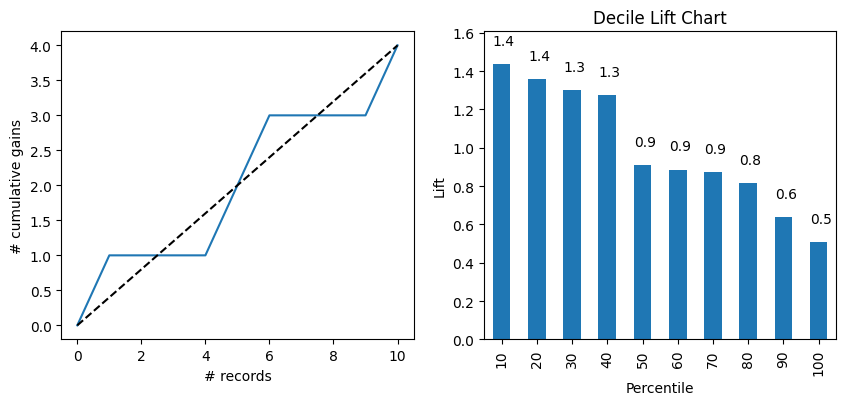

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
gainsChart(logit_result.actual, ax=axes[0])
liftChart(logit_result['p_1'], ax=axes[1])

<Axes: xlabel='# records', ylabel='# cumulative gains'>

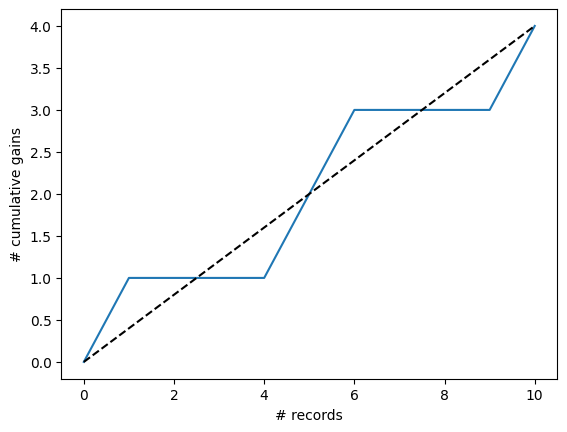

In [71]:
logit_result = logit_result.sort_values(by='p_1', ascending=False)
gainsChart(logit_result.actual)

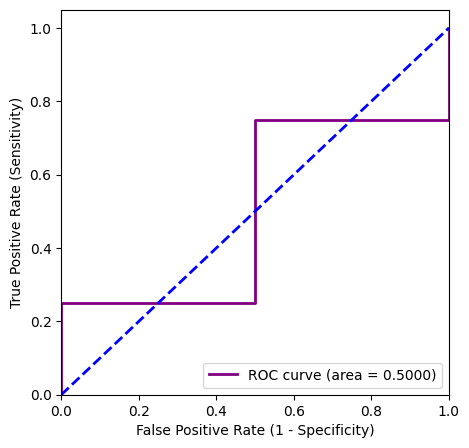

In [72]:
fpr, tpr, _ = roc_curve(logit_result['actual'], logit_result['p_1'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr, color='purple',
 lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")

5. What is the probability that a household with a $60K income and a lot size of 20,000 ft2 is an owner?

In [73]:
Ownership_Nonowner_Riding_Mower= pd.DataFrame({'Income':[60.0],'Lot_Size':[20.0]})
Ownership_Nonowner_Riding_Mower

,Income,Lot_Size
0,60.0,20.0


In [63]:
logit_reg.predict_proba(Ownership_Nonowner_Riding_Mower)

array([[0.6243235, 0.3756765]])

In [ ]:
#From the array displayed,
#The probability of being a non-owner is 0.6243 (62.43%).
#The probability  OF a household  being an owner is 0.3757 (37.57%).

6.	What is the classification of a household with a $60K income and a lot size of 20,000 ft2? Use cutoff = 0.5

In [64]:
logit_reg.predict(Ownership_Nonowner_Riding_Mower)

array([False])

In [ ]:
#Since the probability of being an owner is 0.37, which is less than the cutoff of 0.5, the household is classified as a non-owner.

#Thus, a household with a $60K income and a lot size of 20,000 ft² would be classified as a non-owner